# Mean Force Integration

Import HILLS and COLVAR files, compute the mean force and integrate using the pyMFI (would be) module. 

### 2D - Periodic CV space example - Alanine Dipeptide. 

The path to this notebook is: /Users/matteo/Projects/MFI
folder "AlanineDipeptide_pyMFI" already exists
Total no. of Gaussians analysed: 5000
|50/5000|==> Average Mean Force Error: 67.06110891029202
|100/5000|==> Average Mean Force Error: 62.36999948225979
|150/5000|==> Average Mean Force Error: 56.34525272653561
|200/5000|==> Average Mean Force Error: 49.36989693341429
|250/5000|==> Average Mean Force Error: 43.61555332796889
|300/5000|==> Average Mean Force Error: 45.571179730183154
|350/5000|==> Average Mean Force Error: 44.646997275709474
|400/5000|==> Average Mean Force Error: 41.71750612820734
|450/5000|==> Average Mean Force Error: 48.88028695200727
|500/5000|==> Average Mean Force Error: 46.65903317120246
|550/5000|==> Average Mean Force Error: 54.437825185666725
|600/5000|==> Average Mean Force Error: 51.466173250401795
|650/5000|==> Average Mean Force Error: 51.608330724926155
|700/5000|==> Average Mean Force Error: 47.29854047486577
|750/5000|==> Average Mean Force Error: 44

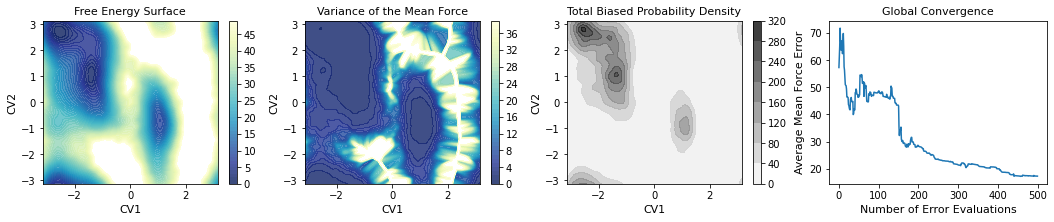

In [1]:
import numpy as np
from pyMFI import MFI

path = os.getcwd()
print("The path to this notebook is:", path)

os.chdir(path)
try: os.mkdir("AlanineDipeptide_pyMFI")
except: print("folder \"AlanineDipeptide_pyMFI\" already exists")
os.chdir("AlanineDipeptide_pyMFI")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS40")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position40")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 2.49, log_pace = 100, error_pace = 500, WellTempered=1, nhills=5000, periodic=1)


print(np.shape(ofe_map))


#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y)

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe_map, ofe_history)

os.chdir(path)


### 2D - Non-periodic case | Bjola potential

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyMFI import MFI
from pyMFI import langevin

path = os.getcwd()
os.chdir(path)
try: os.mkdir("Antoniu_2D_potential")
except: print("folder \"Antoniu_2D_potential\" already exists")
os.chdir("Antoniu_2D_potential")


#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS_potential")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position_potential")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, log_pace = 1, error_pace = 500, nhills=5000)

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y)

#Simpler integration test
[X, Y, FES2] = MFI.intg_2D(Ftot_x, Ftot_y) 

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe_map, ofe_history, FES_lim=20, ofe_map_lim=16)

folder "Antoniu_2D_potential" already exists
Total no. of Gaussians analysed: 5000


### 2D patching independent,  short simulations | Bjola potential

folder "Antoniu_2D_potential" already exists
Simulation: 0
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 190996578.4020599
Simulation: 1
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 12991713.208627705
Simulation: 2
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 4880897.927393261
Simulation: 3
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 62221377.50496842
Simulation: 4
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 107050290.8927461
Simulation: 5
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 79948455.80701613
Simulation: 6
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 39119254.41640855
Simulation: 7
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 297004.33809743344
Simulation: 8
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error:

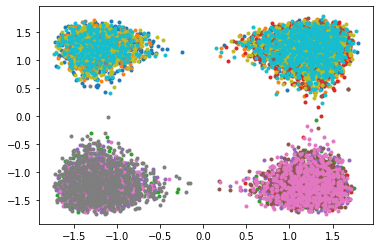

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyMFI import MFI
from pyMFI import langevin

path = os.getcwd()
os.chdir(path)
try: os.mkdir("Antoniu_2D_potential")
except: print("folder \"Antoniu_2D_potential\" already exists")
os.chdir("Antoniu_2D_potential")


nhills = 500
master = []
all_hills= []
ipos=1.3*(2 * np.random.rand(2) - 1)
FP = np.zeros((200,200))

for simulation in np.arange(0,10): 
    #RUN short sim from random location
    #langevin.run_2D(ipos=ipos,tag=simulation)
    #!plumed pesmd < input  >/dev/null
    #Read the HILLS file
    print('Simulation: '+str(simulation))
    HILLS=MFI.load_HILLS_2D(hills_name="HILLS_"+str(simulation))
    plt.plot(HILLS[:,1],HILLS[:,2],'.')
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name="position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, log_pace = 1, error_pace = 1, nhills=nhills)
    master.append([Ftot_den, Ftot_x, Ftot_y, Ftot_den2, ofv_x, ofv_y])
    ipos=1.3*(2 * np.random.rand(2) - 1)    

In [2]:
#Patch
[Ftot_den_patch, Ftot_x_patch, Ftot_y_patch,OFE_map,OFE_history] = MFI.patch_2D(master)

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x_patch, Ftot_y_patch,nbins=(200,200))

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den_patch,OFE_map,OFE_history,FES_lim=20, ofe_map_lim=16)


Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 11.179675188813977
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 8.319299836336574
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 7.945473622876131
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 9.12559841057757


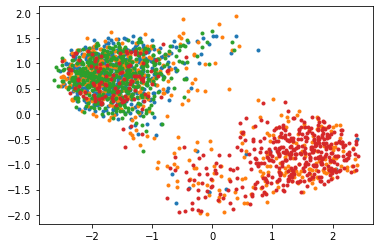

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyMFI import MFI
from pyMFI import langevin

os.chdir(path)
try: os.mkdir("Invernizzi_2D_potential")
except: print("folder \"Invernizzi_2D_potential\" already exists")
os.chdir("Invernizzi_2D_potential")

master = []
all_hills= []
ipos=1.3*(2 * np.random.rand(2) - 1)
FP = np.zeros((200,200))

for simulation in np.arange(0,4): 
    #RUN short sim from random location
    #langevin.run_2D_Invernizzi(ipos=ipos,tag=simulation)
    #!plumed pesmd < input  >/dev/null
    #Read the HILLS file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_"+str(simulation))
    plt.plot(HILLS[:,1],HILLS[:,2],'.')
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name="positioninve_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.12, kT = 1, log_pace = 1, error_pace = 1, nhills=-1)
    master.append([Ftot_den, Ftot_x, Ftot_y])
    FP += Ftot_den
    ipos=1.3*(2 * np.random.rand(2) - 1)
    

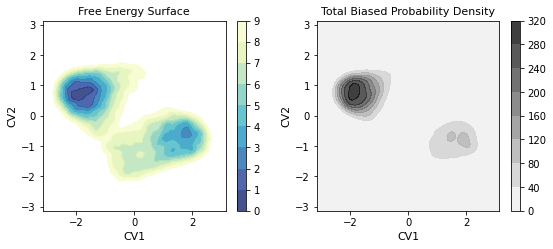

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyMFI import MFI
from pyMFI import langevin

[Ftot_den_patch, Ftot_x_patch, Ftot_y_patch] = MFI.patch_2D(master)

#integration on a periodic domain
[X, Y, FES] = MFI.intg_2D(Ftot_x_patch, Ftot_y_patch)

# Plot Recap
MFI.plot_patch_2D(X, Y, FES, Ftot_den_patch,lim=10)
